## Import libraries

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

c:\Users\esteb\anaconda3\envs\DS_Env_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analysis

In [ ]:
path = kagglehub.dataset_download("dhanushnarayananr/credit-card-fraud")

100%|██████████| 28.9M/28.9M [00:01<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: C:\Users\esteb\.cache\kagglehub\datasets\dhanushnarayananr\credit-card-fraud\versions\1


Import data. In this case I'm using 1/2 of the data for better performance

In [4]:
data = pd.read_csv(path + "/card_transdata.csv", nrows = 500000)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Check data info and description. We can see there are no nulls and all columns are formated to floats.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              500000 non-null  float64
 1   distance_from_last_transaction  500000 non-null  float64
 2   ratio_to_median_purchase_price  500000 non-null  float64
 3   repeat_retailer                 500000 non-null  float64
 4   used_chip                       500000 non-null  float64
 5   used_pin_number                 500000 non-null  float64
 6   online_order                    500000 non-null  float64
 7   fraud                           500000 non-null  float64
dtypes: float64(8)
memory usage: 30.5 MB


In [41]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,26.683361,5.024226,1.825429,0.881668,0.350544,0.101366,0.651040,0.087334
std,65.922348,28.121703,2.821275,0.323001,0.477141,0.301813,0.476642,0.282324
min,0.004874,0.000407,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.880415,0.296336,0.475681,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.986540,0.997728,0.998895,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.811361,3.352337,2.100906,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


## EDA

Let's start by checking the distribution of legitimate vs fraud trasactions for each "Yes/No" feature.

Text(0.5, 1.0, 'Online order transaction by type')

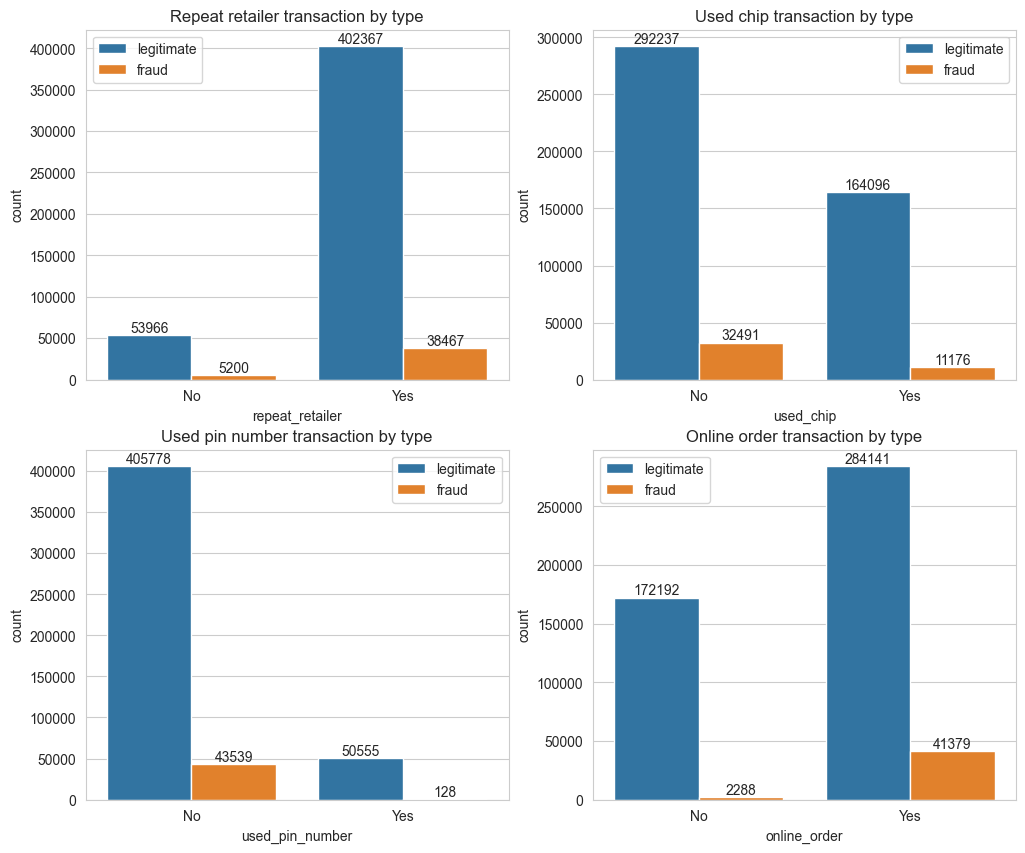

In [42]:
plt.figure(figsize = (12, 10))

plt.subplot(2, 2, 1)
ax = sns.countplot(data = data, x = "repeat_retailer", hue = "fraud", legend = False)
# Add bar label
for i in ax.containers:
    ax.bar_label(i, fmt = "%d")
ax.legend(["legitimate", "fraud"])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Repeat retailer transaction by type")

plt.subplot(2, 2, 2)
ax = sns.countplot(data = data, x = "used_chip", hue = "fraud", legend = False)
# Add bar label
for i in ax.containers:
    ax.bar_label(i, fmt = "%d")
ax.legend(["legitimate", "fraud"])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Used chip transaction by type")

plt.subplot(2, 2, 3)
ax = sns.countplot(data = data, x = "used_pin_number", hue = "fraud", legend = False)
# Add bar label
for i in ax.containers:
    ax.bar_label(i, fmt = "%d")
ax.legend(["legitimate", "fraud"])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Used pin number transaction by type")

plt.subplot(2, 2, 4)
ax = sns.countplot(data = data, x = "online_order", hue = "fraud", legend = False)
# Add bar label
for i in ax.containers:
    ax.bar_label(i, fmt = "%d")
ax.legend(["legitimate", "fraud"])
ax.set_xticklabels(["No", "Yes"])
ax.set_title("Online order transaction by type")

Some findings we can extract from the charts are:
1. 88% of fraudulent transactions were made on the same retailer as the last trasaction.
2. 74% of fraudulent trasanctions were made without using a credit card.
3. Less than 0.3% of fraudulent transactions were made usin a PIN number.
4. More than 94% of fraudulent transactions were performed through an online order.

Let's check the distribution for the variables <code>distance_from_home</code> and <code>distance_from_last_transaction</code> for both legitimate and fraud transactions usinig a violin plot. Since the distribution for the transactions is very skewed, I'm using <code>log_scale = True</code> to better visualize important parameters.

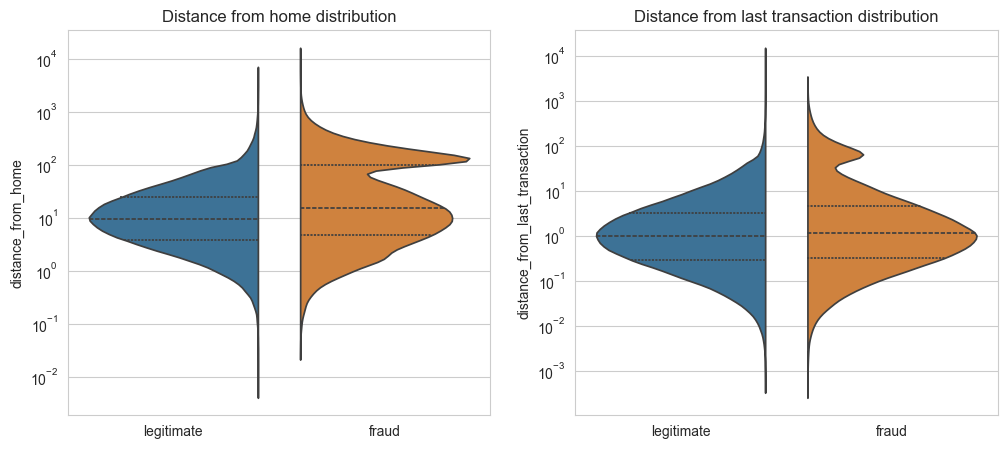

In [43]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
ax = sns.violinplot(data = data, x = "fraud", y = "distance_from_home", hue = "fraud", log_scale = True, split=True, inner="quart", saturation = 0.6, legend = False)
ax.set_xlabel("")
ax.set_xticklabels(["legitimate", "fraud"])
ax.set_title("Distance from home distribution")
plt.subplot(1, 2, 2)
ax = sns.violinplot(data = data, x = "fraud", y = "distance_from_last_transaction", hue = "fraud", log_scale = True, split=True, inner="quart", saturation = 0.6, legend = False)
ax.set_xlabel("")
ax.set_xticklabels(["legitimate", "fraud"])
ax.set_title("Distance from last transaction distribution")
plt.show()

We can see that for both variables the mean of the fraudulent transanctions deviates from the median of legitimate transactions. Also, the distribution of fraudulent transactions differs from the normal distribution, i.e. many fraudulent transactions are located closer to the higher end of the distribution.

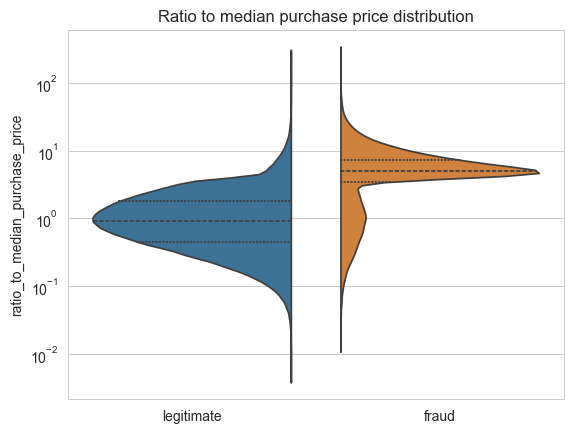

In [44]:
ax = sns.violinplot(data = data, x = "fraud", y = "ratio_to_median_purchase_price", hue = "fraud", log_scale = True, split=True, inner="quart", saturation = 0.6, legend = False)
ax.set_xlabel("")
ax.set_xticklabels(["legitimate", "fraud"])
ax.set_title("Ratio to median purchase price distribution")
plt.show()

We can see a more pronounced pattern. Which could mean that <code>ratio_to_median_purchase_price</code> might be a good predictor. We'll check this later with a correlation matrix.

Let's check the linear relationship between variables.

Text(0.5, 1.0, 'Correlation matrix')

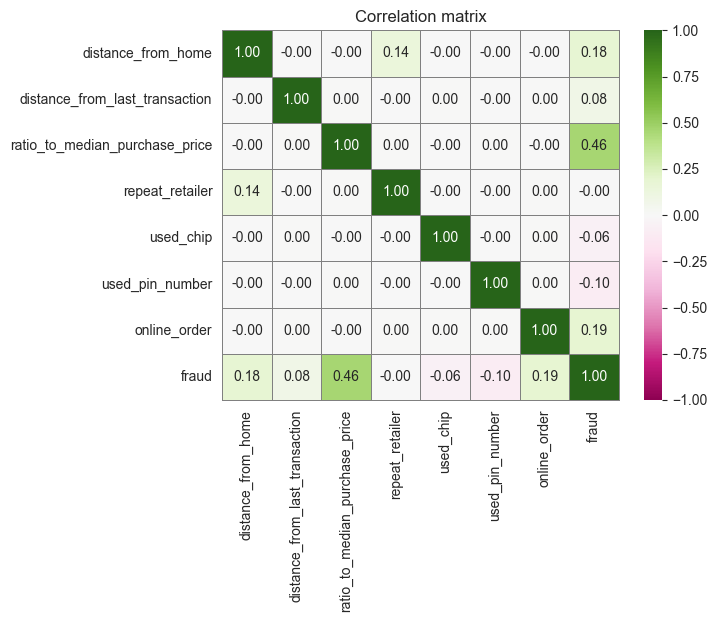

In [45]:
corr = data.corr()
sns.heatmap(corr, annot = True, cmap = "PiYG", fmt = ".2f", linewidth = .5, linecolor = "gray", vmin = -1, vmax = 1, clip_on = False)
plt.title("Correlation matrix")

As stated before, it seems like <code>ratio_to_median_purchase_price</code> is the strongest predictor for fraud in a linear relationship.

## Pre-processing

Let's make a copy of the data for pre-processing

In [46]:
df = data.copy()

Check for duplicates.

In [47]:
print(df.duplicated().sum())

0


Separate x and y from the dataset.

In [48]:
x = df.drop("fraud", axis = 1)
y = df["fraud"]

Standarize the features.

In [49]:
scaler = StandardScaler()
X = scaler.fit_transform(x)

Now we split the data between train and test splits. In this case I'm using a 20% of the data for testing.

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Before proceeding with the model development, let's check the fraud/legitimate ratio for the target variable. We can see that the data show a considerable imbalance.

In [51]:
fraud_ratio = (y_train.value_counts()[1] / len(y_train)) * 100
print(f"fraud ratio {fraud_ratio:.2f}%")

fraud ratio 8.70%


To overcome this problem I'm using SMOTE algorithm for oversampling. Let's check the distribution of the labels after the oversampling.

In [52]:
smote = SMOTE(random_state = 42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

y_train_resampled.value_counts()

fraud
0.0    365196
1.0    365196
Name: count, dtype: int64

Now that the training dataset is balanced we can continue with model development.

## Model development and evaluation

For hyperparameter tuning I'll be using optuna, so let's define the number of trials and an empty array to store each model's accuracy.

In [53]:
model_evaluation = []
n_trials = 8

## Logistic Regression

Let's define the objective for the optuna study. For the logistic regression model we'll tune *C*, *penalty* and *solver*

In [54]:
def objective(trial, x_train, y_train, cv):
    C = trial.suggest_float("C", 1e-3, 10, log = True) # Check C values from 1e-3 to 10
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"]) # Check penalty for l1 and l2 methods
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"]) # For solver check liblinear and saga methods

    model = LogisticRegression(C = C, penalty = penalty, solver = solver, random_state = 42)
    scores = cross_val_score(model, x_train, y_train, cv = cv, scoring = "accuracy") # Using accuracy for scoring
    return scores.mean()

[I 2025-03-25 09:19:41,724] A new study created in memory with name: no-name-2da10789-4e07-466a-8e2a-fce19fc50702
[I 2025-03-25 09:20:50,389] Trial 0 finished with value: 0.9416984304318777 and parameters: {'C': 0.01631659292626662, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.9416984304318777.
[I 2025-03-25 09:20:54,494] Trial 1 finished with value: 0.9418065915289324 and parameters: {'C': 0.011604890284597214, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.9418065915289324.
[I 2025-03-25 09:22:10,043] Trial 2 finished with value: 0.9416628331087964 and parameters: {'C': 1.8682358776559584, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.9418065915289324.
[I 2025-03-25 09:23:24,124] Trial 3 finished with value: 0.9416642022366072 and parameters: {'C': 7.401495514200974, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.9418065915289324.
[I 2025-03-25 09:24:32,690] Trial 4 finished with value: 0.941593007590

Best parameters: {'C': 0.011604890284597214, 'penalty': 'l1', 'solver': 'liblinear'}


Text(50.722222222222214, 0.5, 'Actual label')

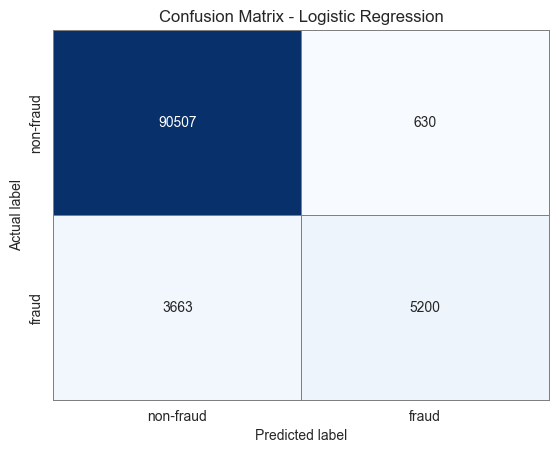

In [55]:
study = optuna.create_study(direction = "maximize") # Maximize accuracy
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42) # Cross validation

# Run optimization
study.optimize(lambda trial: objective(trial, x_train_resampled, y_train_resampled, cv), n_trials = n_trials)

# Print best parameters
print("Best parameters:", study.best_params)

# Train model with best parameters
best_model = LogisticRegression(**study.best_params)
best_model.fit(x_train, y_train)

# Evaluate model
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

# Store model score
model_evaluation.append({
    "Model": "Logistic Regression",
    "Score": accuracy,
})

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues", fmt = "d", cbar = False, linewidths = .5, linecolor = "gray", clip_on = False, xticklabels = ["non-fraud", "fraud"], yticklabels = ["non-fraud", "fraud"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

## KNN Classifier

In [56]:
def objective(trial, x_train, y_train, cv):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 10)

    model = KNeighborsClassifier(n_neighbors = n_neighbors)

    scores = cross_val_score(model, x_train, y_train, cv = cv, scoring = "accuracy")
    return scores.mean()

[I 2025-03-25 09:28:22,522] A new study created in memory with name: no-name-ad08a879-00cb-4a9d-a635-aa6dfd228046
[I 2025-03-25 09:29:49,047] Trial 0 finished with value: 0.9985952748660992 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 0.9985952748660992.
[I 2025-03-25 09:31:07,105] Trial 1 finished with value: 0.9990950065170484 and parameters: {'n_neighbors': 4}. Best is trial 1 with value: 0.9990950065170484.
[I 2025-03-25 09:32:24,813] Trial 2 finished with value: 0.9988157044436412 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.9990950065170484.
[I 2025-03-25 09:33:42,696] Trial 3 finished with value: 0.9988157044436412 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.9990950065170484.
[I 2025-03-25 09:34:59,710] Trial 4 finished with value: 0.9988157044436412 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.9990950065170484.
[I 2025-03-25 09:36:12,263] Trial 5 finished with value: 0.9990950065170484 and parame

Best parameters: {'n_neighbors': 4}


Text(50.722222222222214, 0.5, 'Actual label')

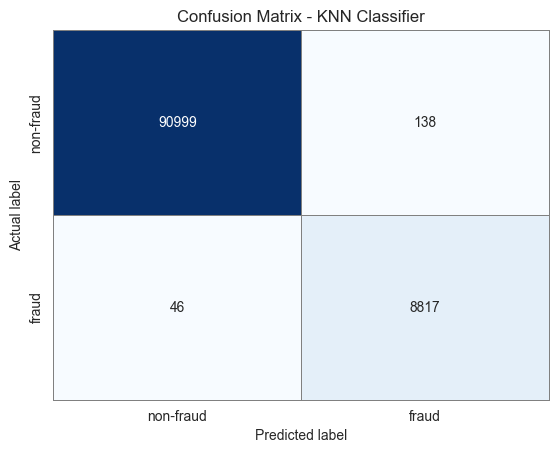

In [57]:
study = optuna.create_study(direction = "maximize") # Maximize accuracy
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42) # Cross validation

# Run optimization
study.optimize(lambda trial: objective(trial, x_train_resampled, y_train_resampled, cv), n_trials = n_trials)

# Print best parameters
print("Best parameters:", study.best_params)

# Train model with best parameters
best_model = KNeighborsClassifier(**study.best_params)
best_model.fit(x_train_resampled, y_train_resampled)

# Evaluate model
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

# Store model score
model_evaluation.append({
    "Model": "KNN Classifier",
    "Score": accuracy,
})  

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues", fmt = "d", cbar = False, linewidths = .5, linecolor = "gray", clip_on = False, xticklabels = ["non-fraud", "fraud"], yticklabels = ["non-fraud", "fraud"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

## Decision Tree

In [58]:
def objective(trial, x_train, y_train, cv):
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 2, 8, log = False)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, log = False)

    model = DecisionTreeClassifier(criterion = criterion, splitter = splitter, max_depth = max_depth, min_samples_split = min_samples_split)

    scores = cross_val_score(model, x_train, y_train, cv = cv, scoring = "accuracy")
    return scores.mean()

[I 2025-03-25 09:39:12,765] A new study created in memory with name: no-name-d655ae12-c2ae-492a-848b-745584f5c7b2
[I 2025-03-25 09:39:19,256] Trial 0 finished with value: 0.9999315436094591 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.9999315436094591.
[I 2025-03-25 09:39:25,515] Trial 1 finished with value: 0.9999342818650806 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 3}. Best is trial 1 with value: 0.9999342818650806.
[I 2025-03-25 09:39:29,547] Trial 2 finished with value: 0.9749203167614103 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 3}. Best is trial 1 with value: 0.9999342818650806.
[I 2025-03-25 09:39:30,416] Trial 3 finished with value: 0.7148175226453739 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 8}. Best is trial 1 with value: 0.9

Best parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 3}


Text(50.722222222222214, 0.5, 'Actual label')

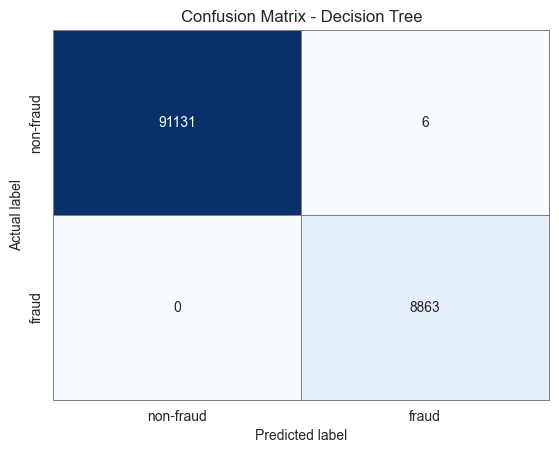

In [59]:
study = optuna.create_study(direction = "maximize") # Maximize accuracy
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42) # Cross validation

# Run optimization
study.optimize(lambda trial: objective(trial, x_train_resampled, y_train_resampled, cv), n_trials = n_trials)

# Print best parameters
print("Best parameters:", study.best_params)

# Train model with best parameters
best_model = DecisionTreeClassifier(**study.best_params)
best_model.fit(x_train_resampled, y_train_resampled)

# Evaluate model
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

# Store model score
model_evaluation.append({
    "Model": "Decision Tree",
    "Score": accuracy,
})

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues", fmt = "d", cbar = False, linewidths = .5, linecolor = "gray", clip_on = False, xticklabels = ["non-fraud", "fraud"], yticklabels = ["non-fraud", "fraud"])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

In [60]:
# Convert results to DataFrame
results = pd.DataFrame(model_evaluation)
results.head()

,Model,Score
0,Logistic Regression,0.95707
1,KNN Classifier,0.99816
2,Decision Tree,0.99994


## Conclusion

Both KNN classifier and Decision Tree perform with an accuracy higher than 96% but the Decision Tree is better at calculating True Negatives which is desired for fraud detection.

## Author
Esteban Sánchez Rojas

## LinkedIn
https://www.linkedin.com/in/esteban-sanchez-r93/